In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
warnings.filterwarnings('ignore')
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import cm
from matplotlib.colors import Normalize


[*********************100%%**********************]  30 of 30 completed


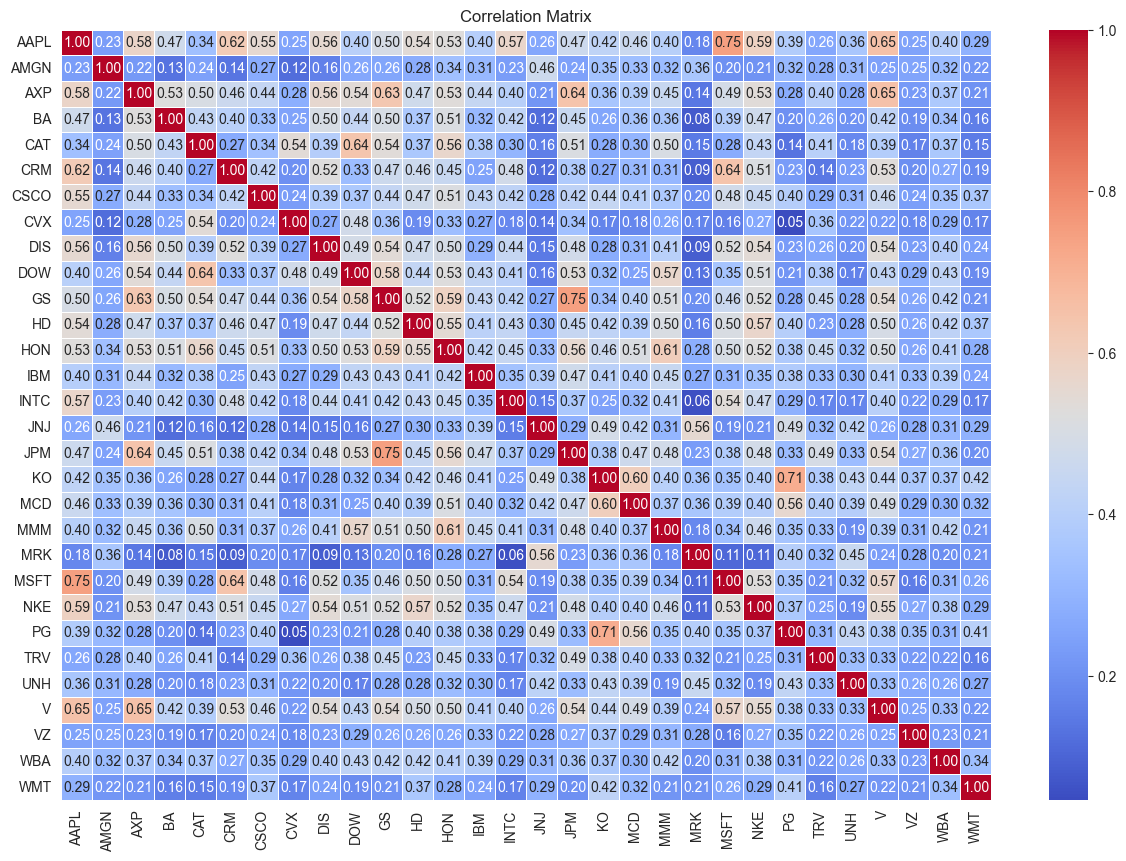

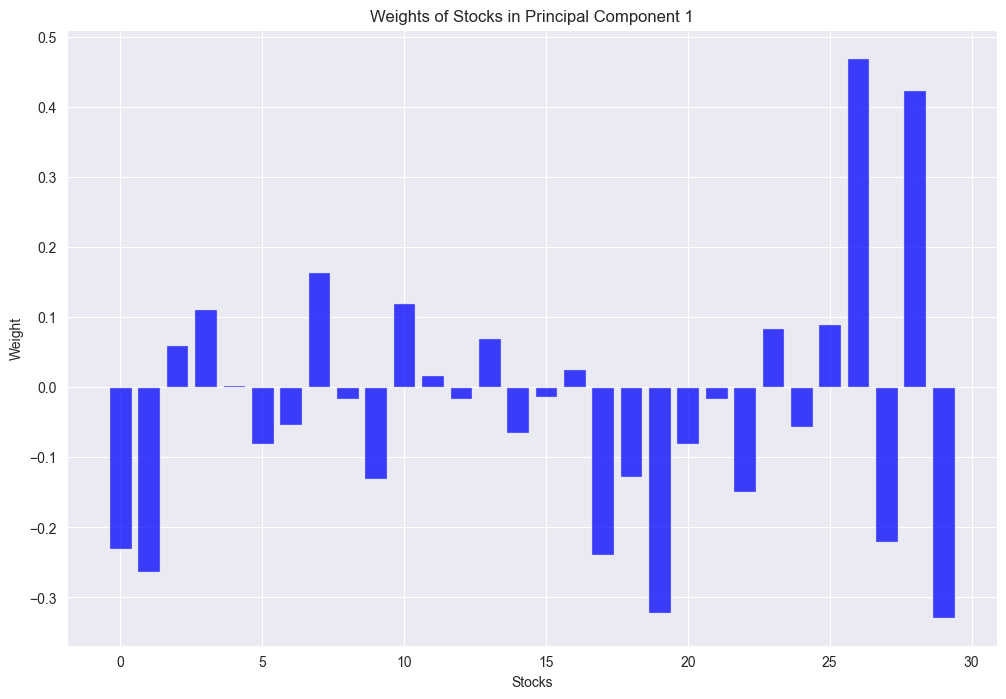

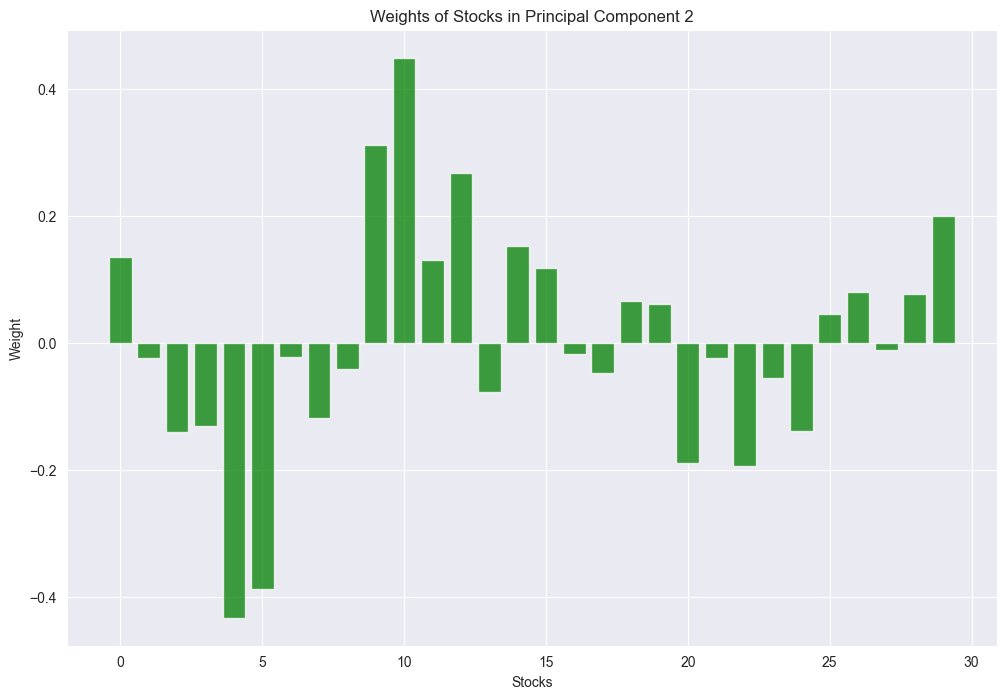

In [2]:
# List of S&P 500 Index constituents
stocks = ["MMM", "AXP", "AMGN", "AAPL", "BA", "CAT", "CVX", "CSCO", "KO", "DIS", "DOW", "GS", "HD", "HON", "IBM", "INTC",
           "JNJ", "JPM", "MCD", "MRK", "MSFT", "NKE", "PG", "CRM", "TRV", "UNH", "VZ", "V", "WBA", "WMT"]

# Download historical data for the specified symbols over the last 2 years
stock_data = yf.download(tickers=stocks, group_by="ticker",period="2y")
returns_df = pd.DataFrame()

# Calculate daily returns for each stock
for i in stock_data.columns.levels[0]:
    returns_df[i] = (stock_data[i]["Adj Close"] / stock_data[i]["Adj Close"].shift(1)) - 1

# Drop NaN values
returns_df.dropna(inplace=True)

# PCA Analysis
pca = PCA()
correlation_matrix = returns_df.corr()
pca_model = pca.fit(correlation_matrix)
pca_components = pca_model.components_

# Plotting correlation matrix heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix")
plt.show()
# Plotting PC1 weights against stocks
pca_weights_df = pd.DataFrame(pca_components)
plt.figure(figsize=(12, 8))
plt.bar(pca_weights_df.index, pca_weights_df[0], alpha=0.75, label='Principal Component 1', color='blue')
plt.gca().update(dict(title="Weights of Stocks in Principal Component 1", xlabel="Stocks", ylabel="Weight"))
plt.show()

# Plotting PC2 weights against stocks
plt.figure(figsize=(12, 8))
plt.bar(pca_weights_df.index, pca_weights_df[1], color='green', alpha=0.75, label='Principal Component 2')
plt.gca().update(dict(title="Weights of Stocks in Principal Component 2", xlabel="Stocks", ylabel="Weight"))
plt.show()


In [3]:
print("Variance: ", pca_model.explained_variance_)  # Explained variance    

Variance:  [3.27028579e-01 1.25031555e-01 7.87577952e-02 4.39004178e-02
 2.98477065e-02 2.58390678e-02 1.97954330e-02 1.81632826e-02
 1.54103020e-02 1.42692619e-02 1.20200147e-02 1.15708246e-02
 1.03225501e-02 9.16186622e-03 8.36121284e-03 7.34495831e-03
 6.83411002e-03 6.01148850e-03 5.89263946e-03 5.28243349e-03
 4.81223729e-03 4.38311016e-03 3.55618630e-03 3.20339197e-03
 2.96458290e-03 2.67433407e-03 2.21240223e-03 1.79002895e-03
 1.64108684e-03 1.88324293e-33]


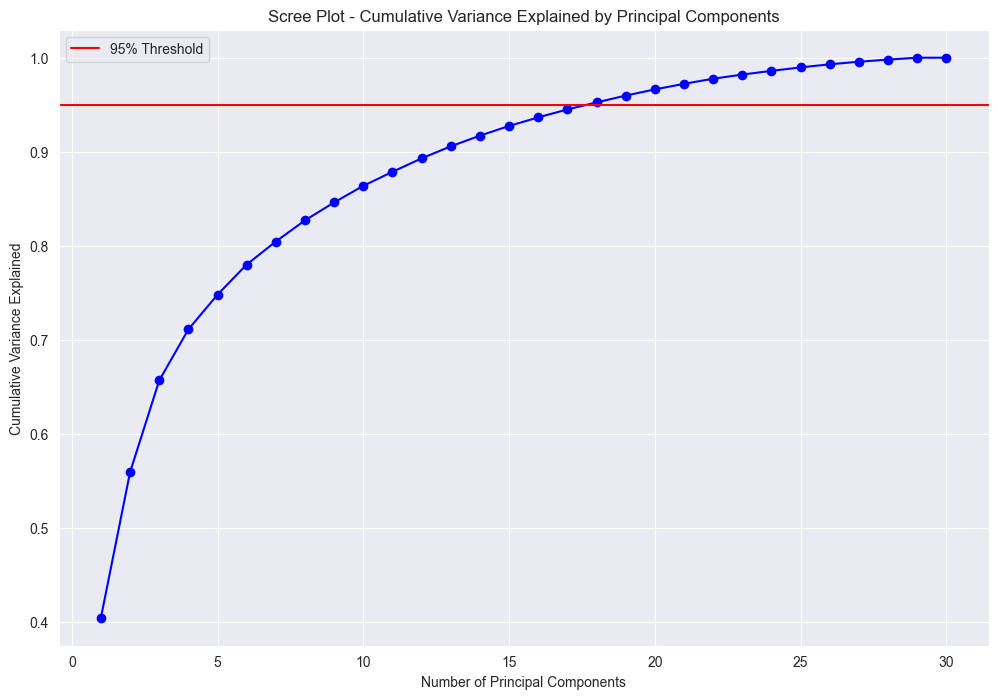

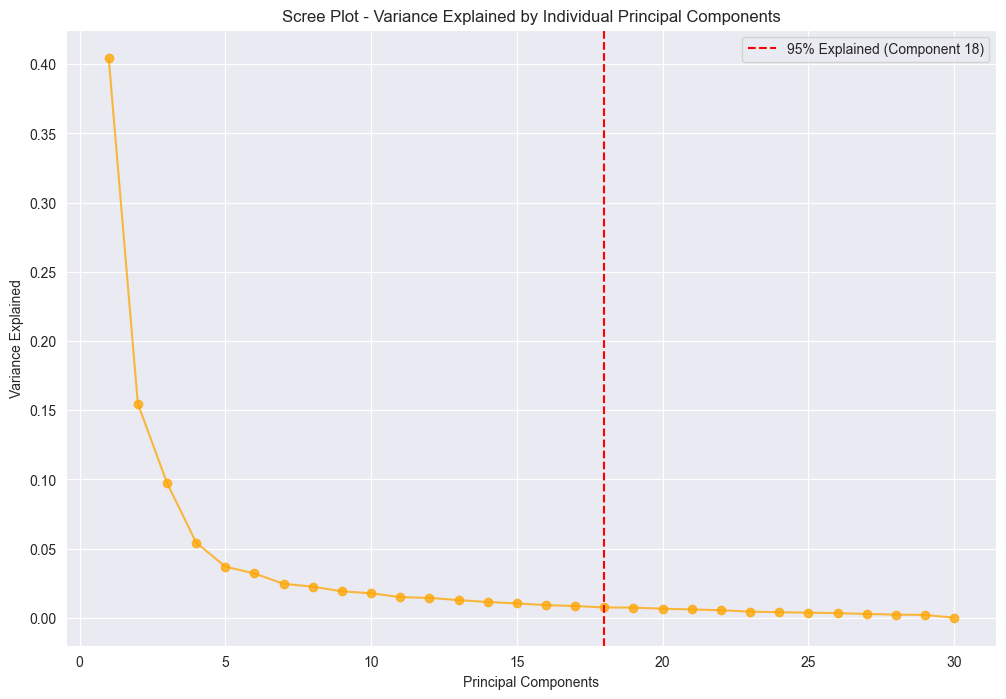

Number of components required to explain 95% of the variance: 18


In [4]:
# Scree plot for the amount of variance explained
plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(pca_model.explained_variance_ratio_) + 1), 
         np.cumsum(pca_model.explained_variance_ratio_), marker='o', linestyle='-', color='blue')
plt.axhline(y=0.95, color='red', linestyle='-', label='95% Threshold')  # Add this line for the 95% threshold
plt.title("Scree Plot - Cumulative Variance Explained by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.legend()  # Add legend to indicate the 95% threshold
plt.grid(True)
plt.show()

# Scree plot for explaining 95% of the variance
cumulative_variance = np.cumsum(pca_model.explained_variance_ratio_)
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

plt.figure(figsize=(12, 8))
plt.plot(np.arange(1, len(pca_model.explained_variance_ratio_) + 1), 
        pca_model.explained_variance_ratio_,  marker='o',color='orange', alpha=0.75)
plt.axvline(num_components_95, color='red', linestyle='--', label=f'95% Explained (Component {num_components_95})')
plt.title("Scree Plot - Variance Explained by Individual Principal Components")
plt.xlabel("Principal Components")
plt.ylabel("Variance Explained")
plt.legend()
plt.grid(True)
plt.show()

# Print the number of components required to explain 95% of the variance
print(f"Number of components required to explain 95% of the variance: {num_components_95}")



In [5]:
print("Variance: ", pca_model.explained_variance_ratio_)  # Explained variance

Variance:  [4.04696839e-01 1.54726157e-01 9.74625240e-02 5.43266291e-02
 3.69364430e-02 3.19757652e-02 2.44967861e-02 2.24770051e-02
 1.90702003e-02 1.76581668e-02 1.48747304e-02 1.43188591e-02
 1.27741232e-02 1.13377807e-02 1.03469746e-02 9.08936283e-03
 8.45718967e-03 7.43919812e-03 7.29212281e-03 6.53699485e-03
 5.95512853e-03 5.42408505e-03 4.40076937e-03 3.96418749e-03
 3.66866202e-03 3.30948000e-03 2.73784080e-03 2.21515520e-03
 2.03083981e-03 2.33050721e-33]


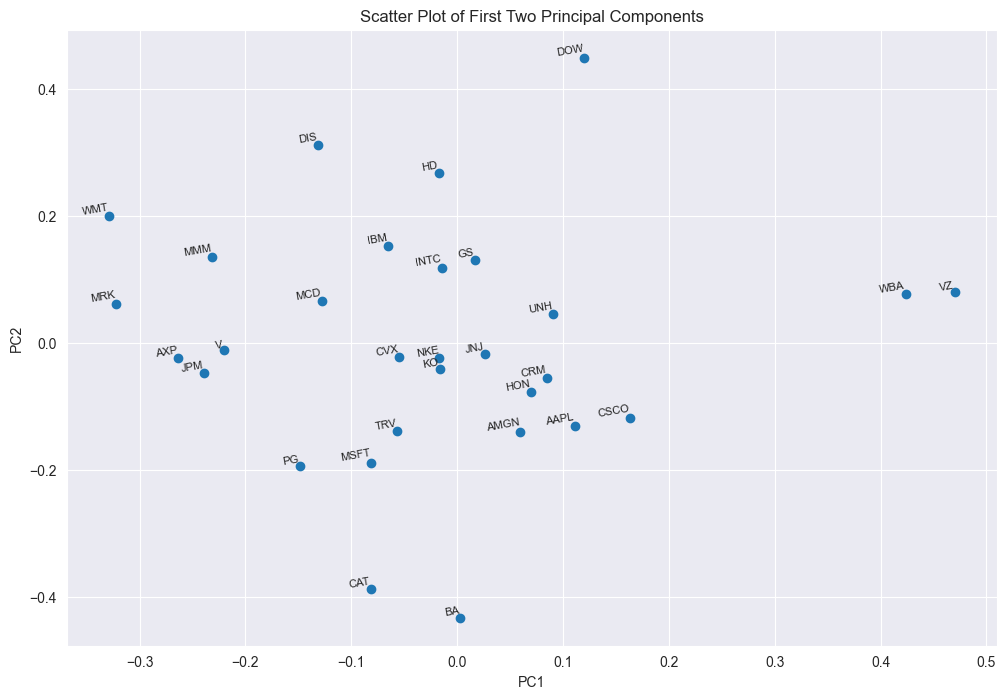

Stocks most distant from mean in PC1: ['VZ', 'WBA', 'WMT']
Stocks most distant from mean in PC2: ['DOW', 'BA', 'CAT']


In [6]:
# Get the first two principal components 
pc1 = pca_weights_df[0]
pc2 = pca_weights_df[1]

# Scatter plot
plt.figure(figsize=(12, 8)) 
plt.scatter(pc1, pc2)

# Annotate points with stock names
for i, stock in enumerate(stocks):
    plt.annotate(stock, (pc1[i], pc2[i]), fontsize=8, rotation=10, ha='right', va='bottom')

plt.title("Scatter Plot of First Two Principal Components")  
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Calculate mean of each PC
pc1_mean = pc1.mean()  
pc2_mean = pc2.mean()

# Distance from the mean
pc1_dist = np.abs(pc1 - pc1_mean)
pc2_dist = np.abs(pc2 - pc2_mean)

# Most distant stocks for PC1
pc1_most_distant = pc1_dist.nlargest(3).index
pc1_most_distant_names = [stocks[i] for i in pc1_most_distant]

# Most distant stocks for PC2
pc2_most_distant = pc2_dist.nlargest(3).index
pc2_most_distant_names = [stocks[i] for i in pc2_most_distant]

# Print stock names directly 
print(f"Stocks most distant from mean in PC1: {pc1_most_distant_names}")
print(f"Stocks most distant from mean in PC2: {pc2_most_distant_names}")


QUESTION 2

In [7]:
Pairwise = (2*(1-correlation_matrix))**0.5
Pairwise

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
AAPL,0.000000,1.238659,0.919295,1.025833,1.151062,0.874022,0.944239,1.222581,0.942977,1.090972,...,1.281467,0.712790,0.905244,1.105602,1.216400,1.131314,0.835447,1.225855,1.098296,1.188635
AMGN,1.238659,0.000000,1.247777,1.316090,1.229790,1.312621,1.205315,1.328024,1.293164,1.217054,...,1.132018,1.263979,1.257217,1.168397,1.196659,1.171174,1.227184,1.221739,1.167448,1.251266
AXP,0.919295,1.247777,0.000000,0.974026,0.996201,1.035883,1.057208,1.198618,0.939306,0.959633,...,1.309160,1.013279,0.964778,1.202847,1.097343,1.200239,0.833512,1.243987,1.121743,1.260881
BA,1.025833,1.316090,0.974026,0.000000,1.067594,1.091226,1.154872,1.225512,1.000566,1.059889,...,1.357914,1.107791,1.025043,1.263154,1.218627,1.262682,1.076780,1.270227,1.148963,1.295992
CAT,1.151062,1.229790,0.996201,1.067594,0.000000,1.208049,1.147965,0.958855,1.101544,0.848608,...,1.304151,1.202588,1.063777,1.314881,1.089005,1.277906,1.104968,1.291006,1.123489,1.301202
CRM,0.874022,1.312621,1.035883,1.091226,1.208049,0.000000,1.072892,1.265595,0.976344,1.160426,...,1.351682,0.843347,0.991409,1.239704,1.308156,1.240624,0.968275,1.266035,1.212126,1.274634
CSCO,0.944239,1.205315,1.057208,1.154872,1.147965,1.072892,0.000000,1.235968,1.106754,1.121381,...,1.268770,1.019986,1.048889,1.099752,1.194221,1.177062,1.040918,1.234954,1.139315,1.124228
CVX,1.222581,1.328024,1.198618,1.225512,0.958855,1.265595,1.235968,0.000000,1.207743,1.019221,...,1.285470,1.292821,1.211911,1.381129,1.134191,1.251437,1.245718,1.277168,1.193823,1.288063
DIS,0.942977,1.293164,0.939306,1.000566,1.101544,0.976344,1.106754,1.207743,0.000000,1.012122,...,1.351292,0.982435,0.954131,1.239372,1.220590,1.262004,0.962320,1.237100,1.099416,1.234717
DOW,1.090972,1.217054,0.959633,1.059889,0.848608,1.160426,1.121381,1.019221,1.012122,0.000000,...,1.316550,1.136360,0.988244,1.253945,1.111541,1.289768,1.071083,1.195140,1.072110,1.273354


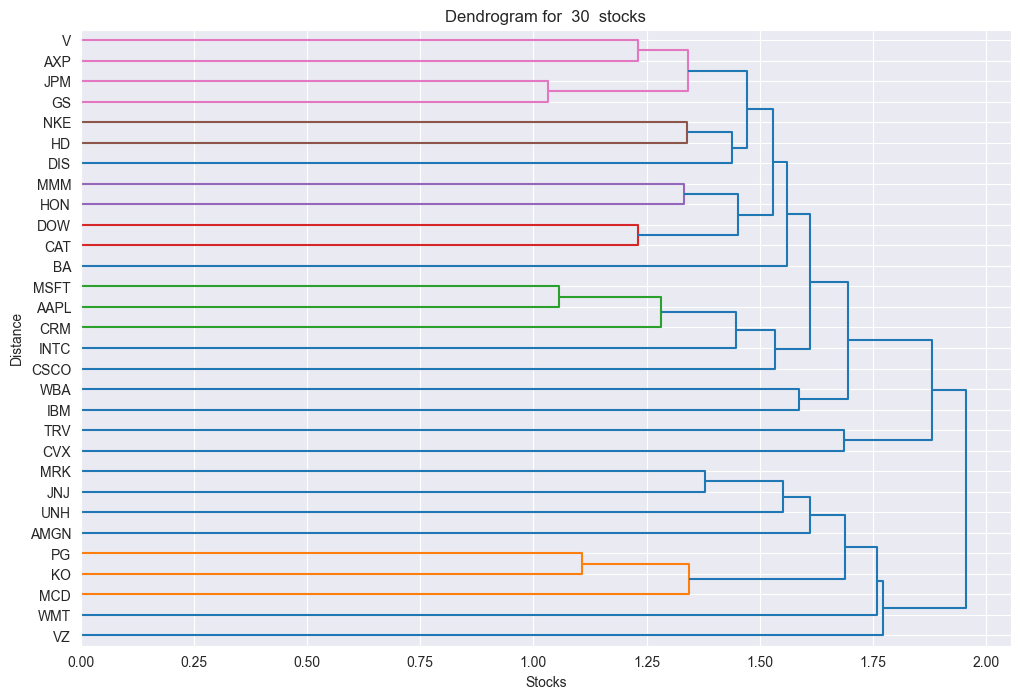

In [8]:

# Use the pairwise distances calculated using the given formula
pairwise_distances = (2 * (1 - correlation_matrix))**0.5

# Perform hierarchical clustering with average linkage
dendogram_matrix = linkage(pairwise_distances, method='average')

# Plot the dendrogram
fig = plt.figure(figsize=(12, 8))
plt.title("Dendrogram for  30  stocks")
plt.xlabel("Stocks")
plt.ylabel("Distance")

# Use stock labels as the column names of the correlation matrix
dendrogram(dendogram_matrix, labels=correlation_matrix.columns, count_sort="ascending", orientation="right")

plt.show()


Stocks in Cluster 0: ['KO', 'DIS', 'GS', 'HD', 'HON', 'JNJ', 'JPM', 'MCD', 'MRK', 'NKE']
Stocks in Cluster 1: ['IBM', 'INTC', 'MSFT', 'CRM', 'TRV', 'UNH', 'VZ', 'V', 'WBA']
Stocks in Cluster 2: ['MMM', 'AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'DOW', 'PG']


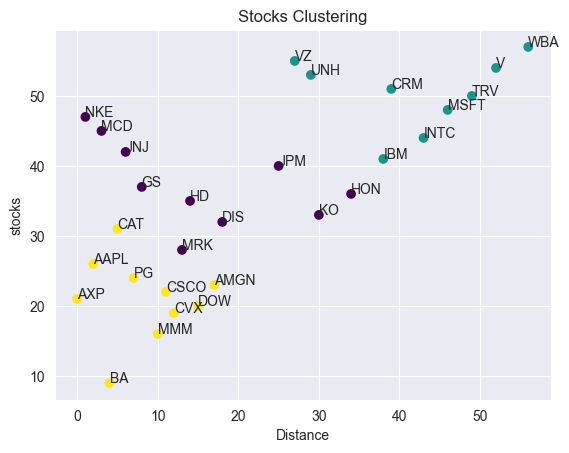

In [9]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
cluster.fit_predict(dendogram_matrix)

labels = cluster.fit_predict(dendogram_matrix)

cluster_0_stocks = []
cluster_1_stocks = []
cluster_2_stocks = []

for i, label in enumerate(labels):
    if label == 0:
        cluster_0_stocks.append(stocks[i])
    elif label == 1:
        cluster_1_stocks.append(stocks[i])
    elif label == 2:
        cluster_2_stocks.append(stocks[i])

print("Stocks in Cluster 0:", cluster_0_stocks)
print("Stocks in Cluster 1:", cluster_1_stocks)
print("Stocks in Cluster 2:", cluster_2_stocks)

plt.scatter(dendogram_matrix[:,0],dendogram_matrix[:,1], c=cluster.labels_, cmap='viridis')
plt.title('Stocks Clustering')  
plt.xlabel('Distance')  
plt.ylabel('stocks')  
#plt.legend()
#annotate
for i, text in enumerate (stocks):
    try:
        plt.annotate(text, (dendogram_matrix[:,0][i],dendogram_matrix[:,1][i]))
    except:
        pass
plt.show()


QUESTION 3

Optimal Number of Trees: 35


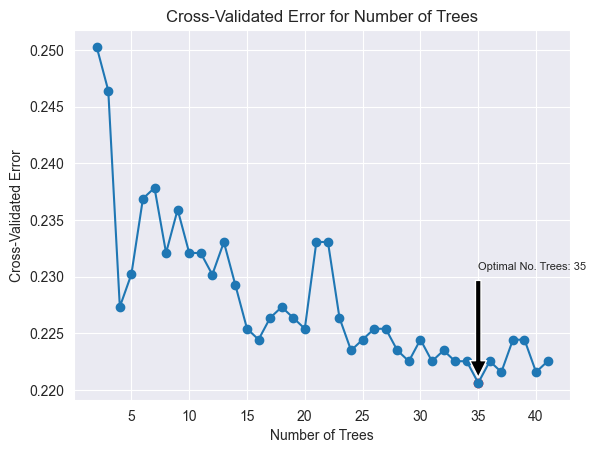

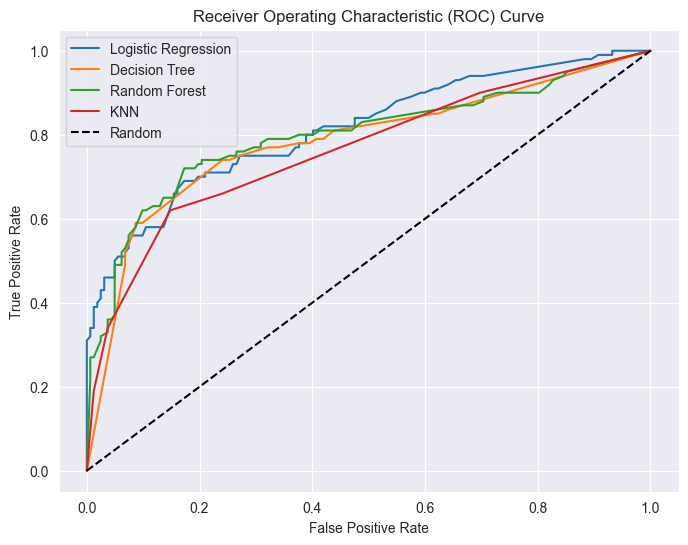

AUC Logistic Regression: 0.8133641975308642
AUC Decision Tree: 0.7833333333333334
AUC Random Forest: 0.7976851851851852
AUC KNN: 0.7639506172839508


In [10]:
# Load the titanic dataset
titanic = pd.read_csv("titanic3.csv")
# Extract necessary columns
titanic = titanic[['age', 'sex', 'pclass', 'survived']]
# Impute missing values using mean
imputer = SimpleImputer(strategy='mean')
titanic['age'] = imputer.fit_transform(titanic[['age']])
# Convert categorical variables to numerical using one-hot encoding
titanic['sex'] = titanic['sex'].map({'female': 0, 'male': 1})
# Extract features and target variable
X = titanic.drop('survived', axis=1)
y = titanic['survived']
# Random Forest model and cross-validation
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=45)
# Range of number of trees to try
num_trees_range = range(2, 42)

# List to store cross-validated error scores
cv_errors = []

# Cross-validation for different number of trees
for num_trees in num_trees_range:
    clf = RandomForestClassifier(n_estimators=num_trees, oob_score=True, random_state=42)
    cv_scores = cross_val_score(clf, XTrain, yTrain, cv=5, scoring='accuracy')
    cv_errors.append(1 - cv_scores.mean())

# Find the optimal number of trees with the minimum cross-validated error
optimal_num_trees = num_trees_range[cv_errors.index(min(cv_errors))]

# Print the optimal number of trees
print("Optimal Number of Trees:", optimal_num_trees)

# Plot the cross-validated error scores for different numbers of trees
plt.plot(num_trees_range, cv_errors, marker='o')
plt.scatter(optimal_num_trees, min(cv_errors), color='red')
plt.annotate(f"Optimal No. Trees: {optimal_num_trees}", 
             xy=(optimal_num_trees, min(cv_errors)), 
             xytext=(optimal_num_trees, min(cv_errors) + 0.01), 
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=8)
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Error')
plt.title('Cross-Validated Error for Number of Trees')
plt.show()

# Initialize models
logreg_model = LogisticRegression(random_state=42)
tree_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

# Fit models
logreg_model.fit(XTrain, yTrain)
tree_model.fit(XTrain, yTrain)
rf_model.fit(XTrain, yTrain)
knn_model.fit(XTrain, yTrain)

# Predict probabilities for ROC analysis
y_logreg_proba = logreg_model.predict_proba(XTest)[:, 1]
y_tree_proba = tree_model.predict_proba(XTest)[:, 1]
y_rf_proba = rf_model.predict_proba(XTest)[:, 1]
y_knn_proba = knn_model.predict_proba(XTest)[:, 1]

# Plot ROC curves
fpr_logreg, tpr_logreg, _ = roc_curve(yTest, y_logreg_proba)
fpr_tree, tpr_tree, _ = roc_curve(yTest, y_tree_proba)
fpr_rf, tpr_rf, _ = roc_curve(yTest, y_rf_proba)
fpr_knn, tpr_knn, _ = roc_curve(yTest, y_knn_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_tree, tpr_tree, label='Decision Tree')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_knn, tpr_knn, label='KNN')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate AUC scores
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_tree = auc(fpr_tree, tpr_tree)
auc_rf = auc(fpr_rf, tpr_rf)
auc_knn = auc(fpr_knn, tpr_knn)

# Print AUC scores
print("AUC Logistic Regression:", auc_logreg)
print("AUC Decision Tree:", auc_tree)
print("AUC Random Forest:", auc_rf)
print("AUC KNN:", auc_knn)

QUESTION 4

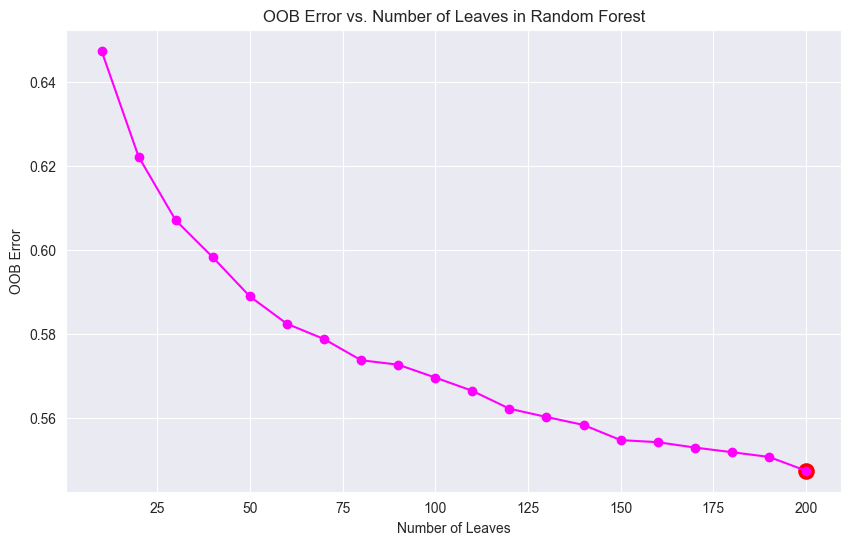

Optimal Number of Leaves: 200
OOB Error at Optimal Point: 0.5474366672968496


In [11]:
# Load red wine dataset
red_wine = pd.read_csv("winequality-red.csv", sep=";")

# 'X_red' contains features and 'y_red' contains labels for red wine
X_red = red_wine.drop('quality', axis=1)
y_red = red_wine['quality']

# Split the data into training and testing sets
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y_red, test_size=0.2, random_state=42)

num_leaves_range = np.arange(10, 201, 10)  # Leaf nodes range
oob_errors = []

for num_leaves in num_leaves_range:
    rf = RandomForestRegressor(n_estimators=100, max_leaf_nodes=num_leaves, oob_score=True, random_state=42)
    rf.fit(X_train_red, y_train_red)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)

optimal_leaves = num_leaves_range[np.argmin(oob_errors)]
optimal_oob_error = min(oob_errors)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_leaves_range, oob_errors, marker='o',color='magenta')
plt.scatter(optimal_leaves, optimal_oob_error, color='red', s=120)
plt.xlabel('Number of Leaves')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Leaves in Random Forest')
plt.grid(True)
plt.show()

print("Optimal Number of Leaves:", optimal_leaves)
print("OOB Error at Optimal Point:", optimal_oob_error)



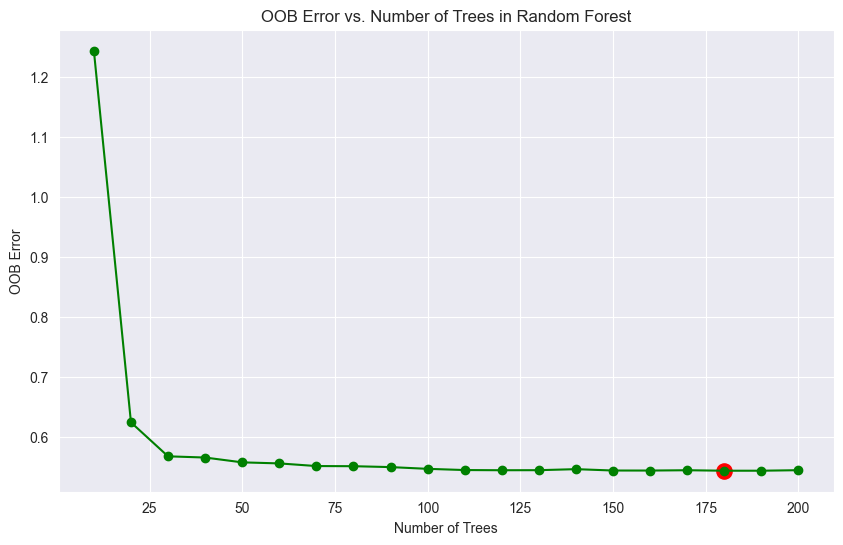

Optimal Number of Trees: 180
OOB Error at Optimal Number of Trees: 0.5442974018206383


In [12]:
num_trees_range = np.arange(10, 201, 10)  # Number of trees range
oob_errors_trees = []

for num_trees in num_trees_range:
    rf = RandomForestRegressor(n_estimators=num_trees, max_leaf_nodes=optimal_leaves, oob_score=True, random_state=42)
    rf.fit(X_train_red, y_train_red)
    oob_error = 1 - rf.oob_score_
    oob_errors_trees.append(oob_error)

optimal_trees = num_trees_range[np.argmin(oob_errors_trees)]
optimal_oob_error_trees = min(oob_errors_trees)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_trees_range, oob_errors_trees, marker='o',color='green')
plt.scatter(optimal_trees, optimal_oob_error_trees, color='red', s=120)
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error')
plt.title('OOB Error vs. Number of Trees in Random Forest')
plt.grid(True)
plt.show()

print("Optimal Number of Trees:", optimal_trees)
print("OOB Error at Optimal Number of Trees:", optimal_oob_error_trees)

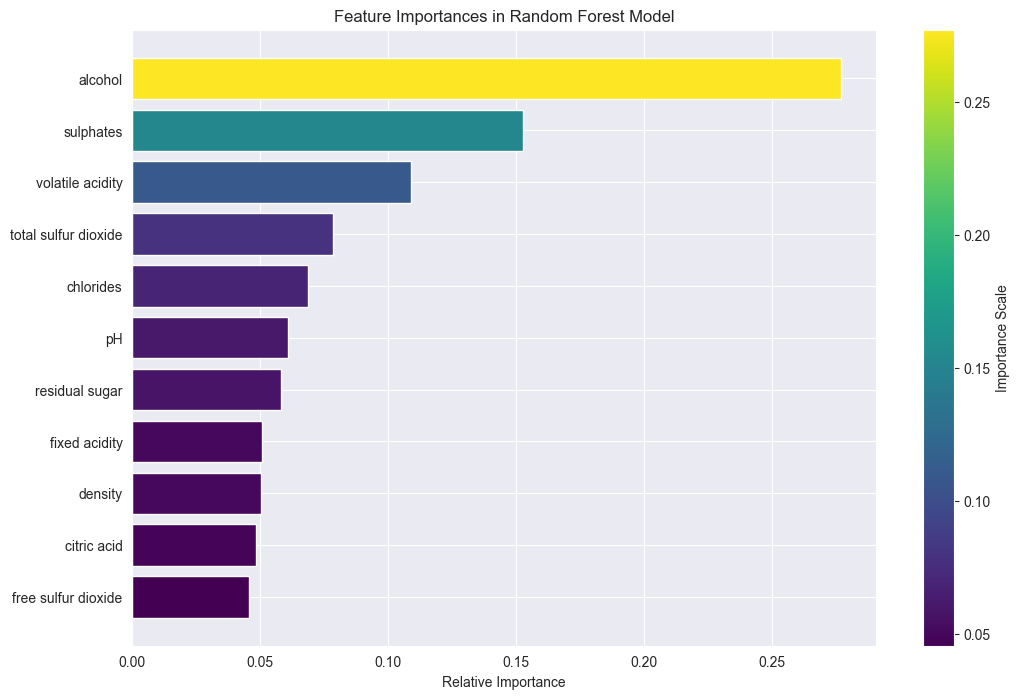

In [13]:

# Train the model
rf_optimal = RandomForestRegressor(n_estimators=optimal_trees, max_leaf_nodes=optimal_leaves, random_state=42)
rf_optimal.fit(X_train_red, y_train_red)

# Feature importance
feature_importances = rf_optimal.feature_importances_

norm = Normalize(vmin=min(feature_importances), vmax=max(feature_importances))
colors = cm.viridis(norm(feature_importances))  # Use colormap from cm

# Sorting feature importances
sorted_idx = np.argsort(feature_importances)
pos = np.arange(sorted_idx.shape[0]) + .5

# Plotting feature importance with color mapping
plt.figure(figsize=(12, 8))
bar_plot = plt.barh(pos, feature_importances[sorted_idx], align='center', color=colors[sorted_idx])
plt.yticks(pos, np.array(X_train_red.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importances in Random Forest Model')

# Optional: Adding a colorbar
sm = plt.cm.ScalarMappable(cmap=cm.viridis, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Importance Scale')

plt.show()


In [14]:
# Predictions and Mean Squared Error
predictions = rf_optimal.predict(X_test_red)
mse = mean_squared_error(y_test_red, predictions)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.30622026903029614
